# Hyperparamètres - Variation du batch_size et des époches

## Objectif
La démarche de recherche avec variation du batch_size va nous permettre de trouver sa valeur optimale pour notre modèle. Mais nous allons cette fois coupler cette recherche avec une variation du nombre d'époches, pour trouver la combinaison idéale de ces deux hyperparamètres.

## Hypothèses
Les hypothèses sont les suivantes :

- Le batch_size va nécessiter un plus grand nombre d'époques pour converger vers un résultat optimal avec une utilisation représentative des données.
- Ces deux hyperparamètres doivent être combinés de manière optimale pour être efficace.

## Étapes de la démarche

- Définir les ranges de batch_size et d'époques à tester.
- Entraîner le modèle avec chaque combinaison de batch_size et époques.
- Observer les résultats obtenus.
- Déterminer la combinaison optimale.

## Conclusion

En conclusion, la GridSearch nous permet d'observer que la meilleure combinaison des deux hyperparamètres serait de 10 époques et 16 batch_size, ce qui nous permettrait d'atteindre une précision de 93%.

Cependant, nous pouvons considérer que la précision obtenue n'est pas beaucoup meilleure qu'initialement, mais aussi que certaines autres combinaisons avec des valeurs plus hautes permettent de s'en rapprocher.

In [2]:
import os
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Check that GPU is used
import tensorflow as tf
from keras import backend as K

tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

tf.compat.v1.reset_default_graph()
K.clear_session()
tf.config.list_physical_devices('GPU')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15356552643250164744
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14905055180075860127
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 32, 32 # Function to load and resize images from a folder

In [4]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
# Generate augmented for the training set
from data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 2954 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 2954
Augmented PNEUMONIA count: 5000


In [6]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

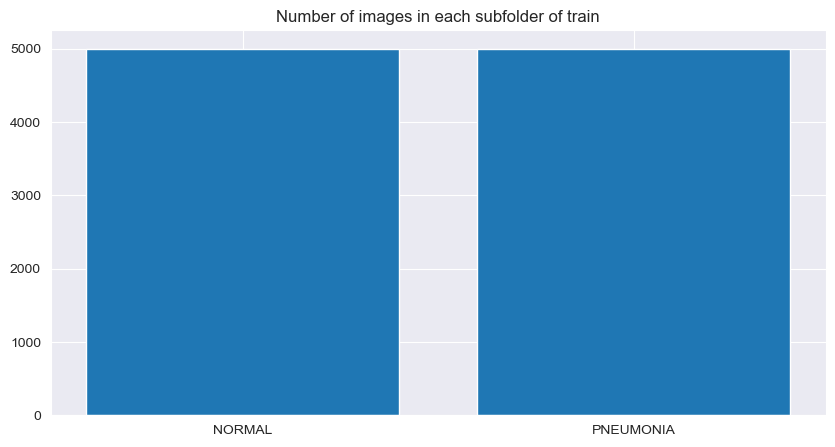

In [7]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

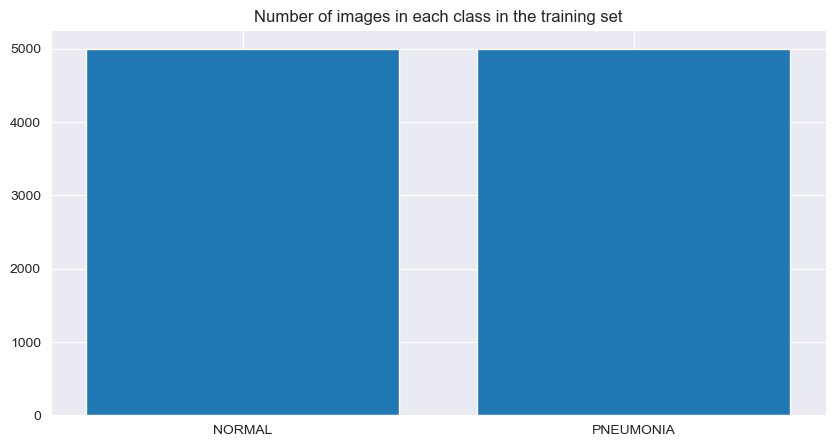

In [8]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [9]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(32, 32, 1)


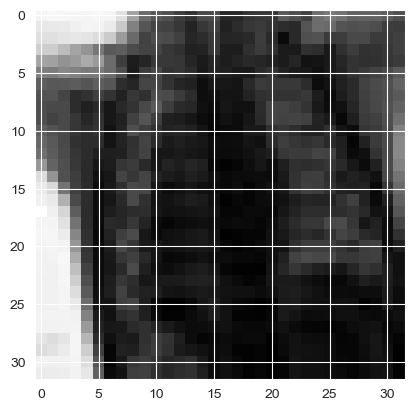

In [10]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [11]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [13]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [14]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the number of folds for cross-validation
n_splits = 5

# Define the range of epochs and batch sizes to try
epochs = [5, 10, 15]
batch_size = [16, 32, 64]

param_grid = {
    'epochs': epochs,
    'batch_size': batch_size
}

datagen = ImageDataGenerator()

# Wrap your create_model function with KerasClassifier
wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)

# Initialize the GridSearchCV object with your wrapped_model, param_grid, and the desired number of folds
grid_search = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, cv=n_splits, return_train_score=True)

# Combine X_train and X_val to use the whole dataset for GridSearchCV
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Fit the GridSearchCV object to your training data
grid_result = grid_search.fit(X_combined, y_combined, callbacks=[early_stop])

# Get the best number of epochs and batch size and the corresponding score
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
best_score = grid_result.best_score_

# Summarize the results
print('Best score: {:.2f} using {} epochs and {} batch size'.format(best_score, best_epochs, best_batch_size))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('Accuracy:', round(mean*1,2), 'with:', param)

C:\Users\proma\AppData\Local\Temp\ipykernel_21884\1261266693.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/5
501/501 [==============================] - 11s 6ms/step - loss: 0.5295 - accuracy: 0.7262 - auc: 0.7819
Epoch 2/5
501/501 [==============================] - 3s 5ms/step - loss: 0.2905 - accuracy: 0.8777 - auc: 0.9449
Epoch 3/5
501/501 [==============================] - 3s 6ms/step - loss: 0.2255 - accuracy: 0.9124 - auc: 0.9666
Epoch 4/5
501/501 [==============================] - 3s 5ms/step - loss: 0.2094 - accuracy: 0.9154 - auc: 0.9711
Epoch 5/5
501/501 [==============================] - 2s 3ms/step - loss: 0.1340 - accuracy: 0.9483 - auc: 0.9879
Epoch 1/5
501/501 [==============================] - 4s 6ms/step - loss: 0.6557 - accuracy: 0.6239 - auc: 0.8588
Epoch 2/5
501/501 [==============================] - 3s 5ms/step - loss: 0.4276 - accuracy: 0.7986 - auc: 0.8742
Epoch 3/5
501/501 [==============================] - 3s 6ms/step - loss: 0.2958 - accuracy: 0.8765 - auc: 0.9424
Epoch 4/5
501/501 [==============================] - 3s 6ms/step - loss: 0.2551 - accuracy: 0.8

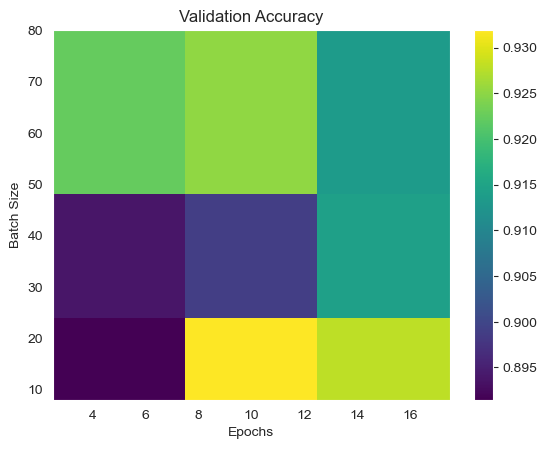

In [15]:
import matplotlib.pyplot as plt

# Extract the validation scores for each parameter combination
val_scores = np.array(means).reshape(len(epochs), len(batch_size))

# Create a meshgrid of epochs and batch sizes for plotting
epoch_mesh, batch_mesh = np.meshgrid(epochs, batch_size)

# Plot the validation scores as a heatmap
plt.pcolormesh(epoch_mesh, batch_mesh, val_scores, cmap='viridis')
plt.colorbar()

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Batch Size')
plt.title('Validation Accuracy')

plt.show()

In [16]:
# Get accuracy scores for each fold (train and validation)
# Initialize lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []

# Get the number of combinations tried during the grid search
n_combinations = len(grid_result.cv_results_['params'])

# Iterate over each combination tried during the grid search
for i in range(n_combinations):
    # Initialize empty lists for loss, accuracy, val_loss, and val_accuracy for this combination
    loss = []
    acc = []
    val_loss = []  # Note: GridSearchCV does not return loss or val_loss
    val_acc = []

    # Iterate through each fold and get the scores for this combination
    for fold in range(n_splits):
        acc.append(grid_result.cv_results_[f'split{fold}_train_score'][i])
        val_acc.append(grid_result.cv_results_[f'split{fold}_test_score'][i])

    # Calculate the mean scores for this combination
    loss_mean = np.nan  # GridSearchCV does not return loss
    acc_mean = np.mean(acc)
    val_loss_mean = np.nan  # GridSearchCV does not return val_loss
    val_acc_mean = np.mean(val_acc)

    # Append the mean scores to the histories list
    history = {
        "loss": loss_mean,
        "accuracy": acc_mean,
        "val_loss": val_loss_mean,
        "val_accuracy": val_acc_mean,
    }
    histories.append(history)

# Calculate mean accuracy scores across all folds for each combination
loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return loss
acc = [np.mean(history["accuracy"]) for history in histories]
val_loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return val_loss
val_acc = [np.mean(history["val_accuracy"]) for history in histories]

print("Loss for each combination: ", loss)
print("Accuracy for each combination: ", acc)
print("Validation loss for each combination: ", val_loss)
print("Validation accuracy for each combination: ", val_acc)

Loss for each combination:  [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Accuracy for each combination:  [0.9398963689804077, 0.9560698986053466, 0.9755139112472534, 0.9461361646652222, 0.9519267916679383, 0.9794826030731201, 0.9398960113525391, 0.9626596570014954, 0.9768865585327149]
Validation loss for each combination:  [nan, nan, nan, nan, nan, nan, nan, nan, nan]
Validation accuracy for each combination:  [0.8914711713790894, 0.9319103121757507, 0.9279154300689697, 0.8937681317329407, 0.8988653659820557, 0.914340615272522, 0.9224219560623169, 0.9252208709716797, 0.9135451078414917]


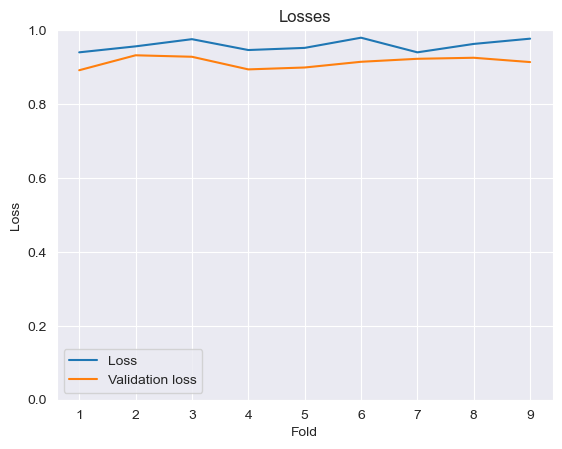

In [17]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

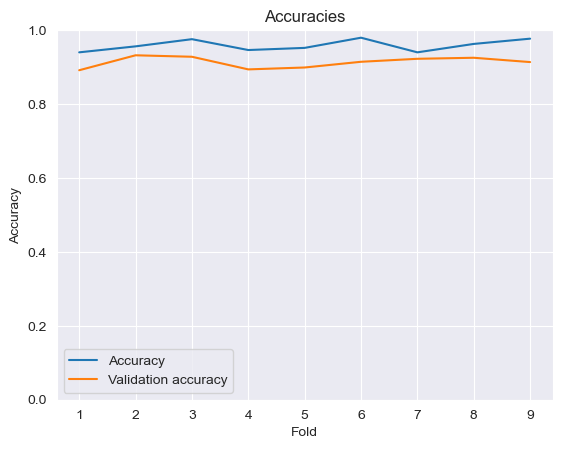

In [18]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=best_batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=best_batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=best_batch_size, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/16
625/625 [==============================] - 6s 9ms/step - loss: 0.4565 - accuracy: 0.7630 - auc: 0.9468 - val_loss: 0.3285 - val_accuracy: 0.8750 - val_auc: 0.9531
Epoch 2/16
625/625 [==============================] - 5s 8ms/step - loss: 0.2512 - accuracy: 0.9004 - auc: 0.9606 - val_loss: 0.2632 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/16
625/625 [==============================] - 5s 7ms/step - loss: 0.2084 - accuracy: 0.9165 - auc: 0.9729 - val_loss: 0.4814 - val_accuracy: 0.7500 - val_auc: 1.0000
Epoch 4/16
625/625 [==============================] - 4s 7ms/step - loss: 0.1824 - accuracy: 0.9293 - auc: 0.9793 - val_loss: 0.2749 - val_accuracy: 0.9375 - val_auc: 0.9375
Epoch 5/16
625/625 [==============================] - 4s 7ms/step - loss: 0.1660 - accuracy: 0.9385 - auc: 0.9824 - val_loss: 0.2577 - val_accuracy: 0.9375 - val_auc: 0.9531
Epoch 6/16
625/625 [==============================] - 5s 8ms/step - loss: 0.1508 - accuracy: 0.9421 - auc: 0.9852 - val_loss: 0.25

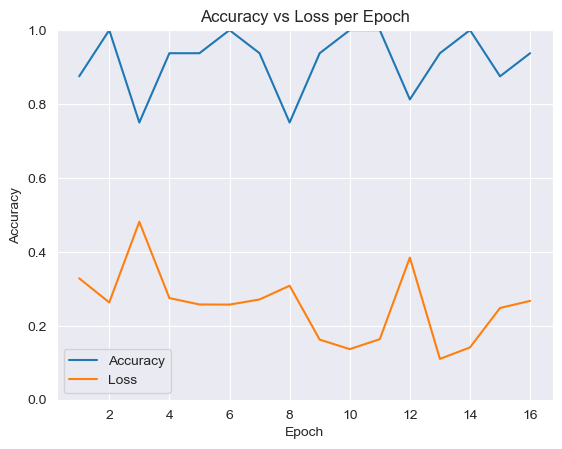

In [20]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 3ms/step


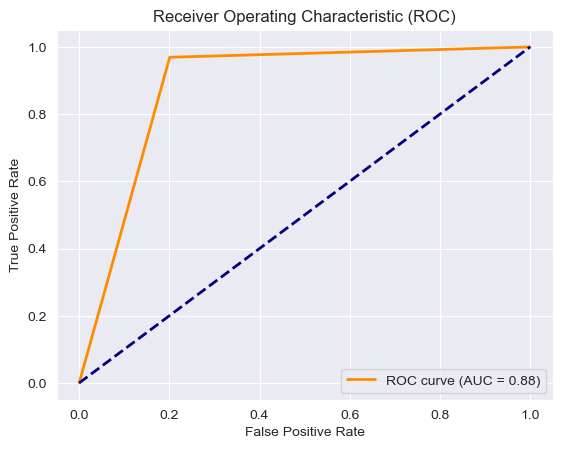

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[187  47]
 [ 12 378]]


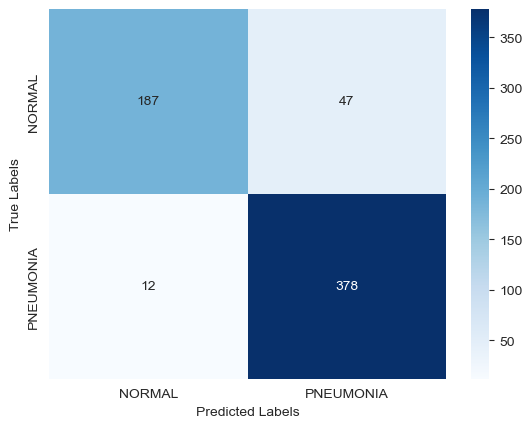

In [24]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [25]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.94      0.80      0.86       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



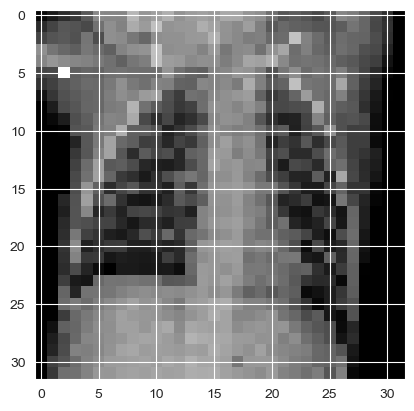

C:\Users\proma\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


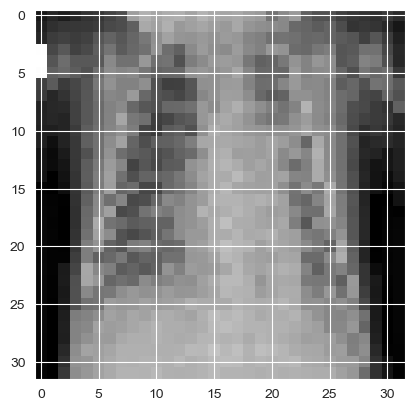

In [26]:
# Heatmaps and Grad-CAM
from cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [27]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [28]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 6, 6, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_140 (Conv2D)         (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 2, 2, 128)      

In [29]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_140"

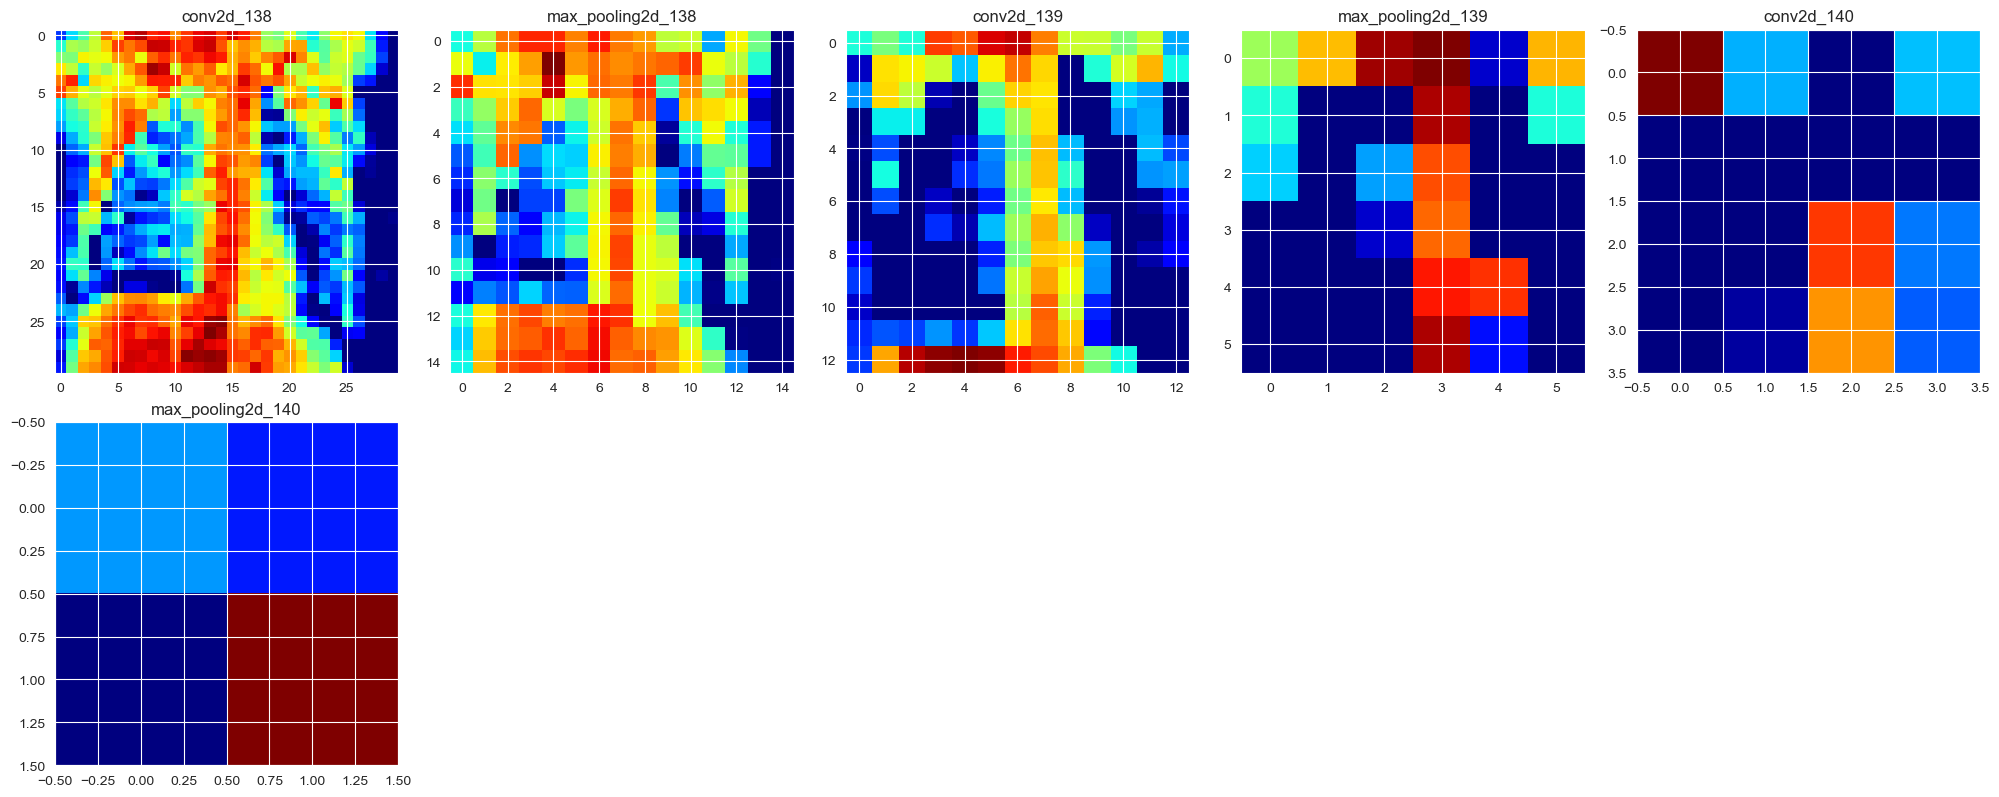

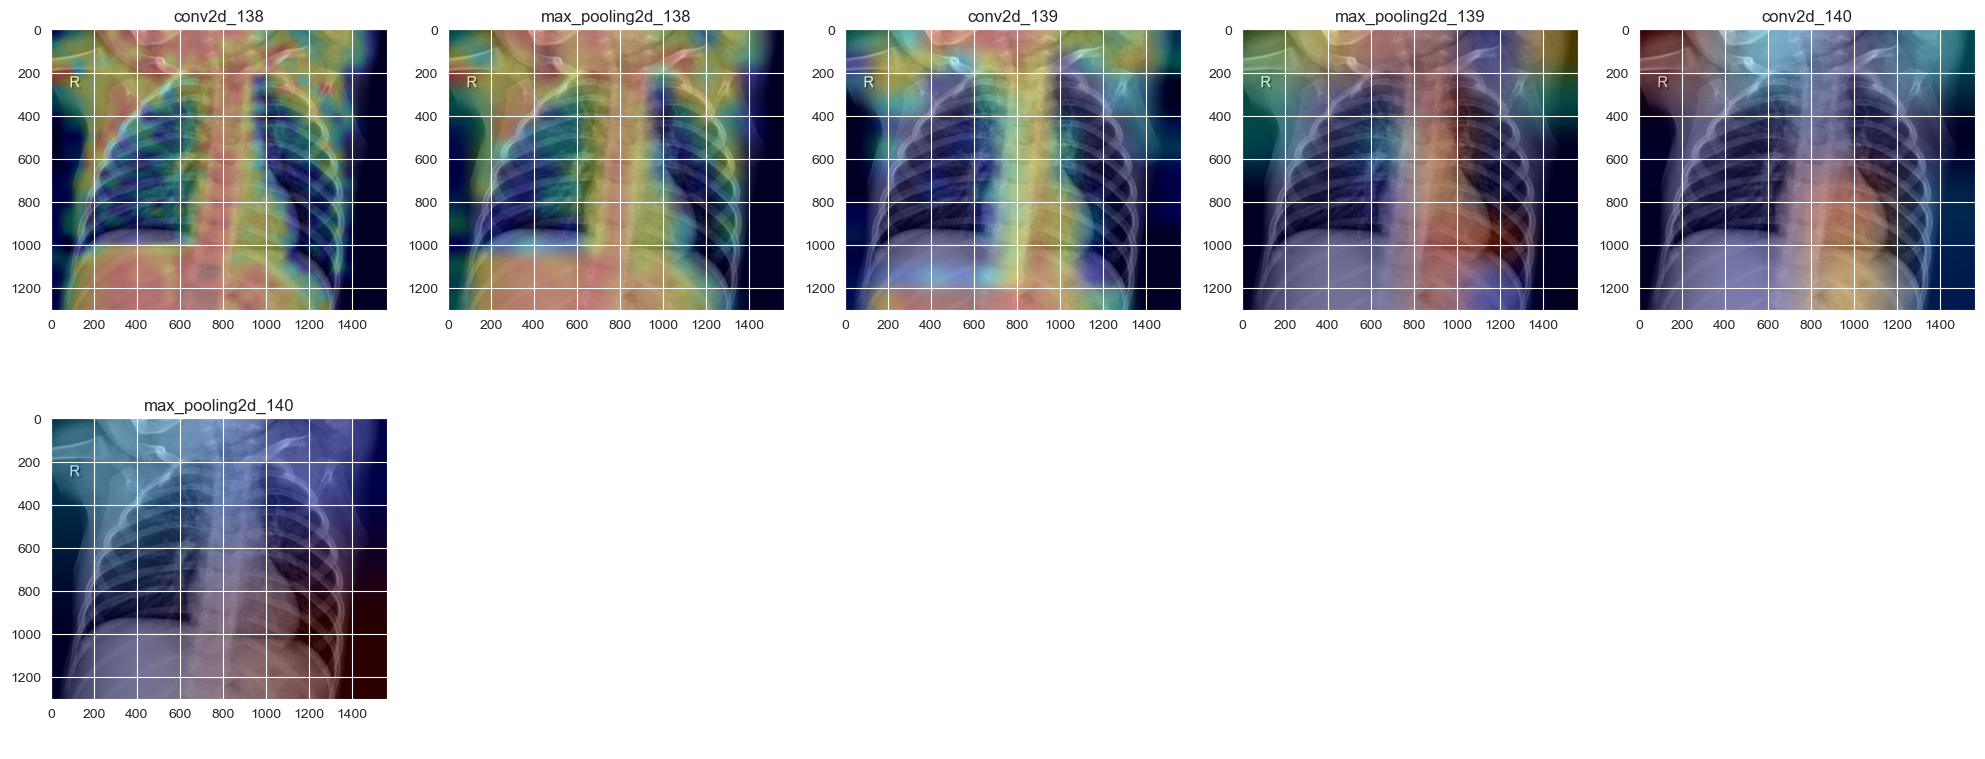

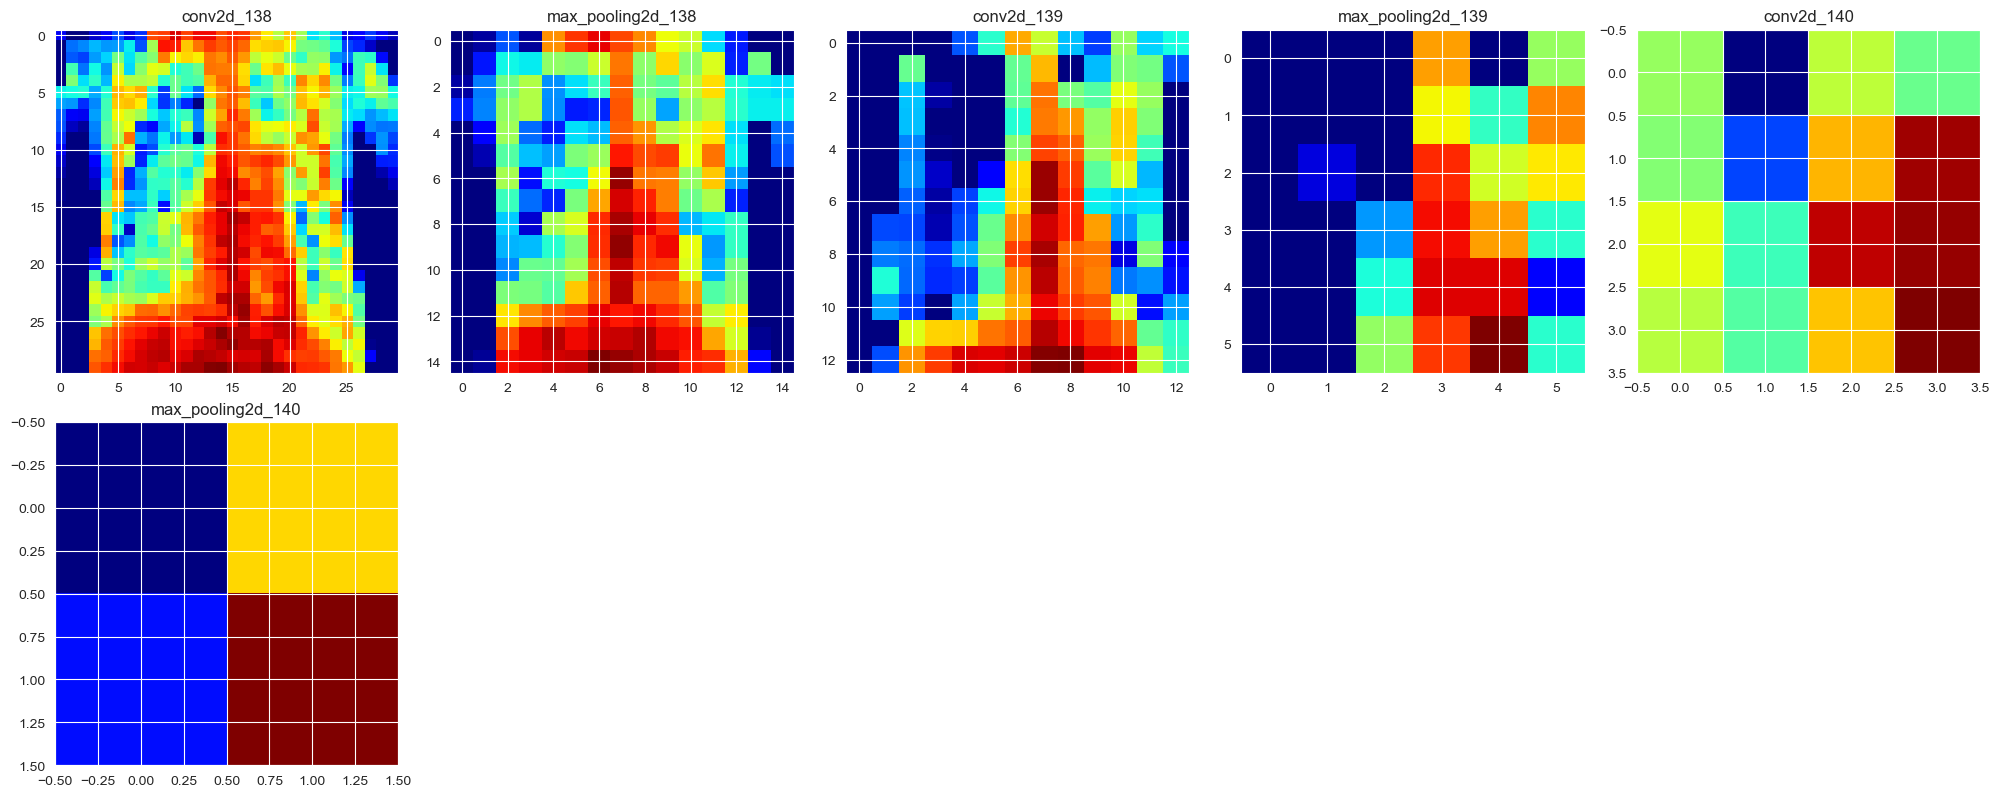

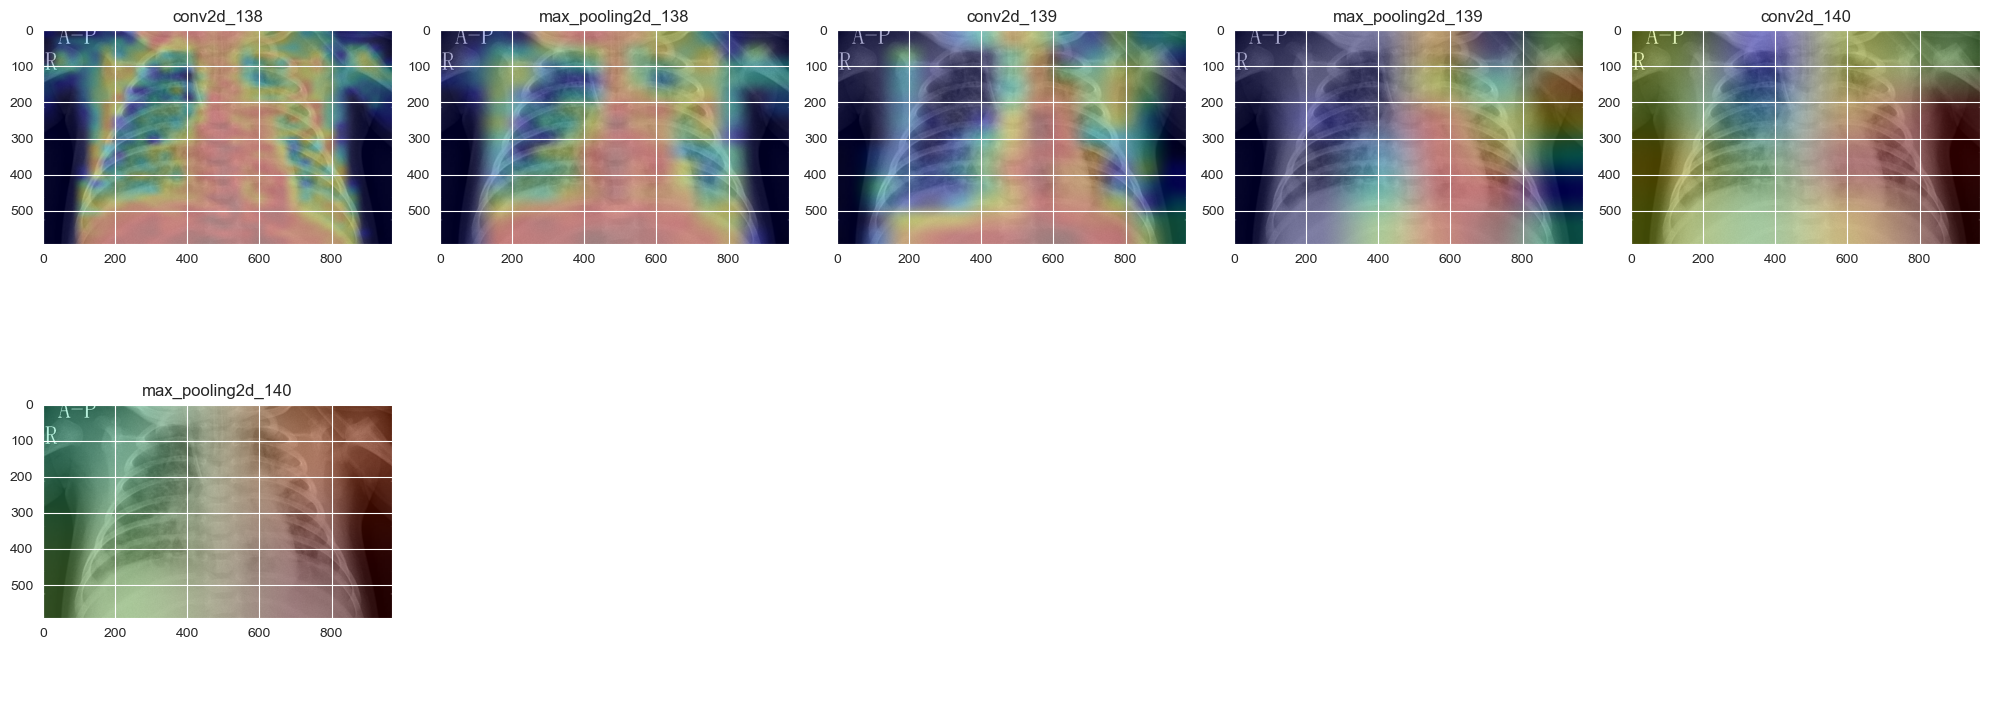

In [30]:
from cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [31]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 291ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 33ms/step
[[1.]]
Predicted class: PNEUMONIA
